
# Preprocessing for MIT data (Binary classification) with MinMax Scaler and Oversamling
The default preprocessing step is what we conclude in our report. 
You can check below what should be input for this notebook and what would be the output if necessary.


Processing **steps** for MIT dataset:   
    resample: Oversampling  
    rescaling: MinMaxScaler  


**Input** : Cleaned data with dummy target variable.   
mitbih_test_clean.csv   
mitbih_train_clean.csv

**Output** : Sampled and Scaled data with dummy target:   
mitbih_binary_train_shift_minmax_oversampling.csv  
mitbih_binary_test_shift_minmax_oversampling.csv



In [109]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
import pywt
from scipy.fft import fft, ifft
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import MinMaxScaler
import sys
import os
import matplotlib.pyplot as plt
from datetime import datetime

# Detect environment and set paths
data_path = ''
data_output_path = ''
if 'google.colab' in sys.modules:
    print("Running on Google Colab")
    # Install required libraries
    !pip install scikit-learn -q
    !pip install pandas -q
    !pip install numpy -q
    !pip install imbalanced-learn -q

    from google.colab import drive
    drive.mount('/content/drive')
    data_path = '/content/drive/MyDrive/Heartbeat_Project/'
    data_output_path = data_path
else:
    print("Running on local environment")
    current_path = os.getcwd()
    print("Current working directory:", current_path)
    data_path = '../data/raw/'
    data_output_path = '../data/processed/'

Running on local environment
Current working directory: g:\Meine Ablage\heartbeat-analysis-ai\notebooks


In [110]:
# File paths
RawFiles = {
    'test': os.path.join(data_path, 'mitbih_test_clean.csv'),
    'train': os.path.join(data_path, 'mitbih_train_clean.csv'),
}

OutputFiles = {
    'test': os.path.join(data_output_path, 'mitbih_binary_test_shift_minmax_oversampling.csv'),
    'train': os.path.join(data_output_path, 'mitbih_binary_train_shift_minmax_oversampling.csv'),
}


In [111]:
def preprocess_dataframe(df):
    """Preprocess DataFrame by adding columns, converting to integers, and mapping targets."""
    # Add column names
    num_columns = df.shape[1]
    feature_columns = [f'c_{i}' for i in range(num_columns - 1)]
    df.columns = feature_columns + ['target']
    
    # Convert target column to integers
    df['target'] = pd.to_numeric(df['target'], errors='coerce')
    df.dropna(subset=['target'], inplace=True)
    df['target'] = df['target'].astype(int)
    # Map target classes
    df['target'] = df['target'].replace({'Normal': 0, 'abnormal': 1})
    return df

In [112]:
# Wavelet-based signal denoising
def wavelet_denoise(ecg_signal, wavelet='db4', level=9):
    coeffs = pywt.wavedec(ecg_signal, wavelet, level=level)
    coeffs[:4] = [np.zeros_like(c) for c in coeffs[:4]]  # Remove high-frequency noise
    return pywt.waverec(coeffs, wavelet)


# Align and pad signals
def align_and_pad_signals(data, target_length=188, sampling_rate=360):
    """Align signals based on R-peak and pad to target length."""
    aligned_data = []
    intervals = []
    for _, row in data.iterrows():
        signal = row.values[:-1]
        denoised_signal = wavelet_denoise(signal)
        r_peaks = find_or_detect_r_peaks(denoised_signal, sampling_rate=sampling_rate)
        shift = target_length // 2 - r_peaks[0] if len(r_peaks) > 0 else 0
        shifted_signal = np.roll(denoised_signal, shift)
        padded_signal = np.pad(shifted_signal, (0, max(0, target_length - len(shifted_signal))), 'constant')[:target_length]
        aligned_data.append(padded_signal)
    return pd.DataFrame(aligned_data)


C:\Users\Isabell Gurstein\AppData\Local\Temp\ipykernel_10104\2010919174.py:4: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187) have mixed types. Specify dtype option on import or set low_memory=False.
  mitbih_train = pd.read_csv(RawFiles['train'], header=None)
C:\Users\Isabell Gurstein\AppData\Local\Temp\ipykernel_10104\2010919174.py:5: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,

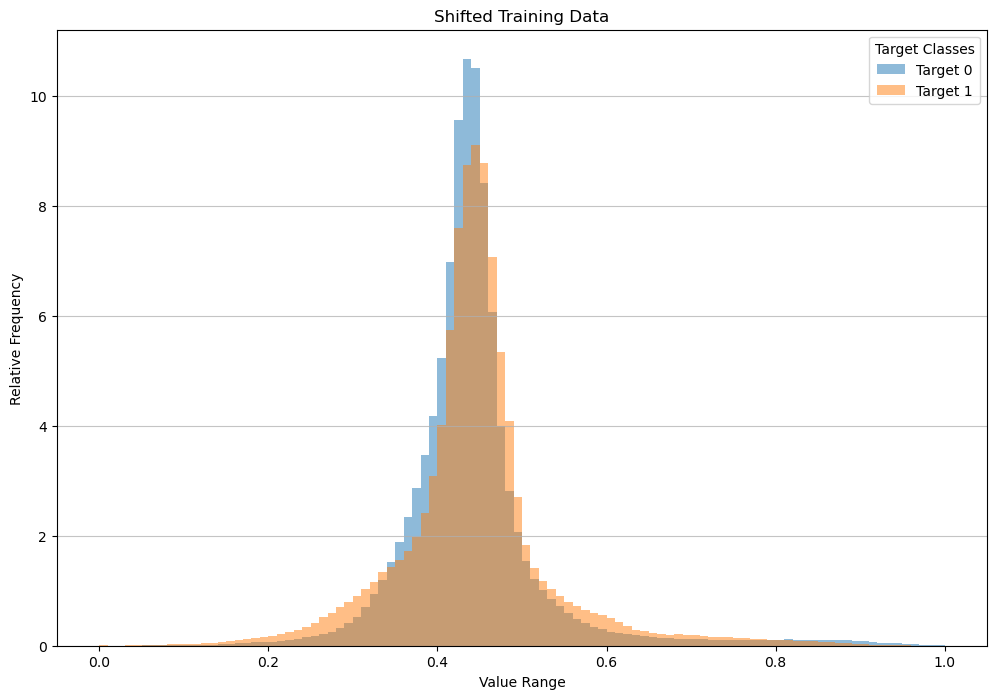

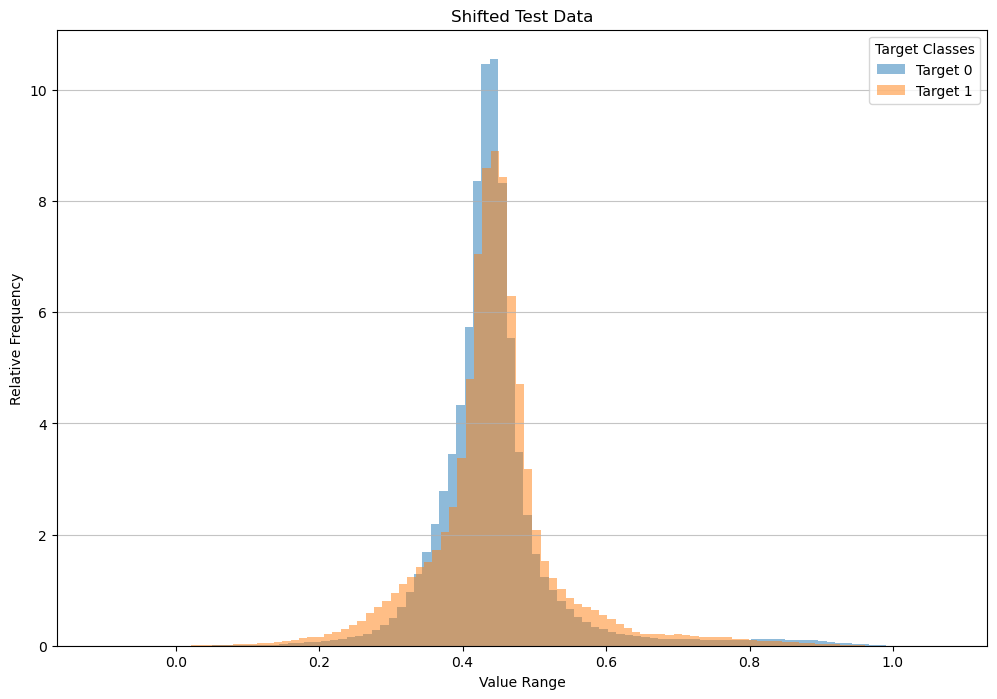

Data processing complete!


In [113]:
# Load, preprocess, and process data
def process_data():
    # Load data
    mitbih_train = pd.read_csv(RawFiles['train'], header=None)
    mitbih_test = pd.read_csv(RawFiles['test'], header=None)

    # Preprocess data
    for df in [mitbih_train, mitbih_test]:
        preprocess_dataframe(df)

    # Align and pad signals
    aligned_train_data = align_and_pad_signals(mitbih_train)
    aligned_test_data = align_and_pad_signals(mitbih_test)

    # Add targets back
    aligned_train_data['target'] = mitbih_train['target'].values
    aligned_test_data['target'] = mitbih_test['target'].values

    # Oversample training data
    X_train = aligned_train_data.drop(columns=['target'])
    y_train = aligned_train_data['target']
    ros = RandomOverSampler(random_state=42)
    X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

    # Scale the data
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train_resampled)
    X_test_scaled = scaler.transform(aligned_test_data.drop(columns=['target']))

    # Combine scaled features and targets
    shifted_train_clean = pd.concat([pd.DataFrame(X_train_scaled), pd.DataFrame(y_train_resampled, columns=['target'])], axis=1)
    shifted_test_clean = pd.concat([pd.DataFrame(X_test_scaled), aligned_test_data['target'].reset_index(drop=True)], axis=1)

    # Save processed data
    os.makedirs(data_output_path, exist_ok=True)
    shifted_train_clean.to_csv(OutputFiles['train'], index=False)
    shifted_test_clean.to_csv(OutputFiles['test'], index=False)

    # Plot histograms
    plot_histograms_by_target(shifted_train_clean, 'target', "Shifted Training Data")
    plot_histograms_by_target(shifted_test_clean, 'target', "Shifted Test Data")
    print("Data processing complete!")


# Call the main processing function
process_data()

# **ECG Signal Preprocessing Documentation**

This documentation outlines the functionality and processes implemented in the code for preprocessing ECG signals, detecting peaks, aligning signals, and preparing the dataset for machine learning.


## **Overview**

The code processes ECG signals using various signal processing techniques, prepares the data for classification tasks, and ensures data integrity through preprocessing, alignment, scaling, and oversampling. This pipeline is designed for efficient and accurate heartbeat classification.

## **Pipeline Workflow**

### **1. Environment Setup**
The code detects the runtime environment (e.g., Google Colab or local) and configures file paths accordingly:
- **Google Colab**: Mounts Google Drive and sets paths for raw and processed data.
- **Local Environment**: Uses relative paths for accessing data files.


### **2. File Paths**
Defined file paths for raw and processed data:
- **RawFiles**: Contains paths for raw training and test datasets (`mitbih_train_clean.csv`, `mitbih_test_clean.csv`).
- **OutputFiles**: Specifies locations to save the processed datasets after preprocessing.


### **3. Preprocessing Functions**

#### **3.1 `preprocess_dataframe`**
Combines multiple preprocessing steps:
1. Adds column names for features and the target.
2. Converts the `target` column to integers.
3. Handles NaN values and removes invalid rows.
4. Maps target classes:
   - `Normal` → 0
   - `Abnormal` → 1

#### **3.2 Wavelet Denoising (`wavelet_denoise`)**
Denoises ECG signals using a discrete wavelet transform (`db4`). It removes high-frequency noise by zeroing out the first four levels of wavelet coefficients.


### **4. Signal Processing**

#### **4.1 Fractional Fourier Transform (`frft`)**
Computes the fractional Fourier transform of an ECG signal. This enhances signal peaks, making them easier to detect.

#### **4.2 Peak Detection**
- **`find_or_detect_r_peaks`**:
  - Detects R-peaks in the ECG signal using the `find_peaks` function from `scipy.signal`.
  - Returns either all detected R-peaks or the highest peak.
- **`detect_all_peaks`**:
  - Detects additional peaks (P, Q, S, T) relative to R-peaks using defined search intervals.

#### **4.3 Interval Calculation**
- **`calculate_intervals`**:
  - Calculates PR, QT, and RR intervals from the detected peaks.
  - Intervals are crucial for diagnosing cardiac conditions.


### **5. Signal Alignment and Padding**
- **`align_and_pad_signals`**:
  - Aligns ECG signals by centering them around the first R-peak.
  - Pads the signal to a fixed target length (default: 188 samples) to ensure uniformity across samples.


### **6. Data Processing**

#### **6.1 Oversampling**
- Uses **Random Oversampling** with `RandomOverSampler` to balance the class distribution in the training dataset.

#### **6.2 Scaling**
- Scales all features using `MinMaxScaler` to normalize values between 0 and 1. This ensures uniformity and helps machine learning models converge faster.



### **7. Data Export**
- Processed training and test datasets are saved as CSV files in the `OutputFiles` directory for later use.


### **8. Visualization**
- **`plot_histograms_by_target`**:
  - Generates histograms of feature distributions by target classes.
  - Provides insights into data distribution and overlap between classes.


## **Pipeline Implementation**

### **Functions**
1. **Preprocessing**:
   - `preprocess_dataframe`
   - `wavelet_denoise`
2. **Signal Processing**:
   - `frft`
   - `find_or_detect_r_peaks`
   - `detect_all_peaks`
   - `calculate_intervals`
3. **Alignment and Padding**:
   - `align_and_pad_signals`
4. **Data Preparation**:
   - Oversampling using `RandomOverSampler`
   - Scaling using `MinMaxScaler`
5. **Visualization**:
   - `plot_histograms_by_target`


## **Output**
1. **Processed Data Files**:
   - Training Dataset: `mitbih_binary_train_shift_minmax_oversampling.csv`
   - Test Dataset: `mitbih_binary_test_shift_minmax_oversampling.csv`
2. **Visualizations**:
   - Histograms showing feature distributions for each target class.


## **Key Features**
1. **Robust Signal Denoising**:
   - Removes noise using wavelet transform for accurate peak detection.
2. **Class Balancing**:
   - Balances training data using oversampling to improve model performance on imbalanced datasets.
3. **Normalization**:
   - Scales features between 0 and 1 for uniformity across variables.


## **Next Steps**
1. **Feature Engineering**:
   - Extract additional features (e.g., RR interval variance, peak amplitude ratios) to improve model performance.
2. **Modeling**:
   - Use the processed data to train and evaluate machine learning models.
3. **Cross-Validation**:
   - Perform cross-validation to ensure generalization to unseen data.


## **Source**
https://www.nature.com/articles/s41598-021-97118-5#further-reading

https://www.youtube.com/watch?v=3tfin4sSBFQ


In [115]:
# Display the running time
print("Current time:", datetime.now())

Current time: 2024-12-08 10:59:04.732212
